# 0. Environment setup

Environment check

In [ ]:
!pip --version

## 0.1 Install transferwee

In [ ]:
!git clone https://github.com/iamleot/transferwee

## 0.2 Install labelImg

In [ ]:
!git clone https://github.com/tzutalin/labelImg

In [ ]:
!pip install pyqt5 lxml --upgrade
!cd labelImg && pyrcc5 -o libs/resources.py resources.qrc

Launch labelimg

In [ ]:
!cd labelImg && python labelimg.py

## 0.3 Packages setup

Torch might come pre-installed

In [ ]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio===0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Required packages

In [ ]:
!pip install -U matplotlib
#!pip install -U albumentations
!pip install wandb
!pip install pafy
!pip install youtube-dl==2020.12.2
!pip install ipywidgets
!pip install opencv-python --upgrade

Yolov5 installation

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r ./yolov5/requirements.txt

## 0.4 Global imports

In [ ]:
import torch
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
import cv2
from pathlib import Path
from glob import glob
import random
import pafy
from PIL import Image
import albumentations as A

# 0.5 Global functions

Runs model on youtube video

In [ ]:
def youtube_test(vid_url):
    streams = pafy.new(vid_url).videostreams

    def filter_res(x):
        w, h = x.resolution.split('x')
        return int(w) > 640 and int(w) <= 1280

    streams_filtered = list(filter(filter_res, streams))

    if not streams_filtered:
        raise Exception("Video doesn't contain small resolution")

    video = streams_filtered[0]    
    cap = cv2.VideoCapture(video.url)

    while cap.isOpened():
        _, img = cap.read()

        detection = model(img)

        cv2.imshow("Detection", np.squeeze(detection.render()))
        if cv2.waitKey(10) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# 1. General model test

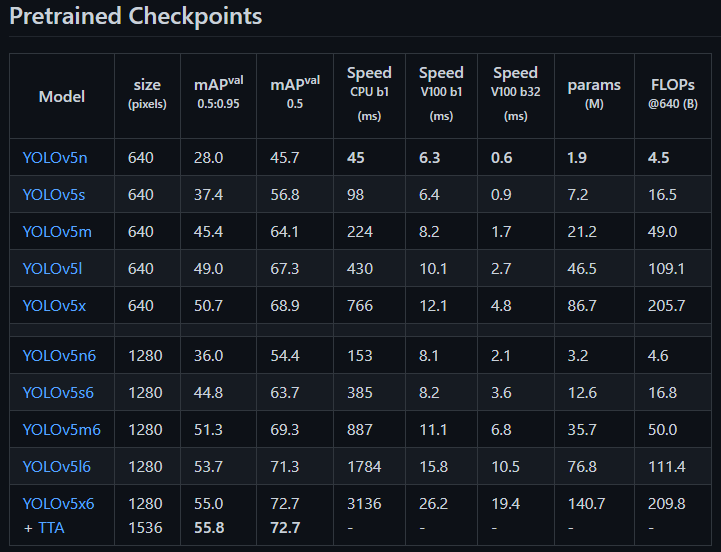

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5m')

## 1.1 Image test

In [ ]:
%matplotlib inline

results = model('https://p1.pxfuel.com/preview/411/31/645/traffic-jam-vehicles-highway.jpg')
results.print()

plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(np.squeeze(results.render()))

## 1.2 Video test

In [ ]:
youtube_test("https://www.youtube.com/watch?v=GlCazmVBUMg")

# 2 Train model

## 2.1 Download dataset

In [ ]:
#https://we.tl/t-jjxOe2OThS <-- new
!cd transferwee && python transferwee.py download https://we.tl/t-55YN9QkpTG -o "../data/data.zip"

import zipfile
with zipfile.ZipFile("data/data.zip", "r") as zip_ref:
    zip_ref.extractall(".")

## 2.2 Image augmentation

In [ ]:
transform = A.Compose([
                A.HorizontalFlip(),
                A.ShiftScaleRotate(border_mode=cv2.BORDER_CONSTANT, rotate_limit=50, scale_limit=(-0.65,0.35)),
                A.Blur(p=0.2),
                A.MedianBlur(p=0.3),
                A.RandomBrightnessContrast(),
                A.RandomGamma(gamma_limit=(80, 120), p=0.3),
                A.ImageCompression(quality_lower=75, p=0.5),
                A.Perspective(),
])

#albumentations.augmentations.transforms.LongestMaxSize()

def show_images(images):
    n = len(images)
    f = plt.figure(figsize=(20,20))
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])
    plt.show(block=True)

correct_mask = np.array(Image.open(random.choice(glob(f"data/correct_mask_train/*.jpg"))));

augmented_imgs = []

for i in range(7):
    augmentations = transform(image=correct_mask)
    img = augmentations["image"]
    augmented_imgs.append(img)

show_images(augmented_imgs)

## 2.3 Train using labels

In [ ]:
!cd yolov5 && python train.py --img 640 --batch 28 --epochs 500 --data ../dataset.yaml --weights yolov5m.pt

# 3 Loading custom model

## 3.0 Downloading pre-trained model

In [ ]:
!cd transferwee && python transferwee.py download https://we.tl/t-oedfKVsBAU -o "../weights/best.pt"

## 3.1 Loading model

In [ ]:
res640 = lambda img: A.Compose([A.LongestMaxSize(max_size=640, always_apply=True)])(image = img)["image"]

#path = "yolov5/runs/train/exp/weights/last.pt"
path = "weights/yolov5mbest.pt"
model = torch.hub.load("ultralytics/yolov5", "custom", path=path)

## 3.1 Test using random images from data folder

In [ ]:
%matplotlib inline

def rand_img(rel_path):
    return transform(image=res640(np.array(Image.open(random.choice(glob(f"data/{rel_path}/*.jpg"))))))["image"]

correct_mask = rand_img("correct_mask_test")
incorrect_mask = rand_img("incorrect_mask_test")
no_mask = rand_img("no_mask_test")

results = [model(correct_mask), model(incorrect_mask), model(no_mask)]
for r in results:
    r.print()

f, axarr = plt.subplots(1,3)
f.set_figheight(20)
f.set_figwidth(20)
f.tight_layout()

results_s = [np.squeeze(r.render()) for r in results]
for i, ax in enumerate(axarr):
    ax.axis('off')
    ax.imshow(results_s[i])
#[ax.imshow(results_s[i]) for i, ax in enumerate(axarr)]

## 3.2 Video detection

In [ ]:
youtube_test("https://www.youtube.com/watch?v=MHW7qjGW540")

## 3.3 Live detection using camera

In [ ]:
cam = cv2.VideoCapture(0)
while cam.isOpened():
    _, img = cam.read()
    detection = model(res640(img))
    
    cv2.imshow("Detection", np.squeeze(detection.render()))
    if cv2.waitKey(10) == ord('q'):
        break
cam.release()
cv2.destroyAllWindows()